## ZerotoGans Course Project

### Image classification using the Intel Image Classification dataset

In [153]:
!pip install jovian --upgrade --quiet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### Add the dataset using the add data section

- Name of dataset: intel-image-classification

### Exploring the data

In [154]:
import os

root_dir="../input/intel-image-classification"
train=root_dir+"/seg_train/seg_train"
testing=root_dir+"/seg_test/seg_test"

In [155]:
class_names=os.listdir(train)
class_names

['mountain', 'street', 'buildings', 'sea', 'forest', 'glacier']

In [156]:
# Calculate the total amount of images in each category in the train and test dataset

dict_of_image_train=dict()
dict_of_image_test=dict()

def obtain_no_image_in_each_category(path,dict_name):
    for category in os.listdir(path):
        for image in os.listdir(path+"/"+category):
            if category not in dict_name.keys():
                dict_name[category]=1
            else:
                dict_name[category]+=1
    return dict_name


print(obtain_no_image_in_each_category(train,dict_of_image_train))
print(obtain_no_image_in_each_category(testing,dict_of_image_test))

{'mountain': 2512, 'street': 2382, 'buildings': 2191, 'sea': 2274, 'forest': 2271, 'glacier': 2404}
{'mountain': 525, 'street': 501, 'buildings': 437, 'sea': 510, 'forest': 474, 'glacier': 553}


In [157]:
### Obtain the minimum number of images of a category in the testing or train dataset

def getMinNoImageForEachCategory(dict_name,classes):
    for label,no_of_images in dict_name.items():
        if classes[0]==label:
            min_no=no_of_images
        else:
            if no_of_images<min_no:
                min_no=no_of_images
    return min_no

min_no_train=getMinNoImageForEachCategory(dict_of_image_train,class_names)
min_no_test=getMinNoImageForEachCategory(dict_of_image_test,class_names)


## Standardise the number of image in each_category 

### To prevent the data from being unbalanced (might not work as well in this case since the data is quite balanced)

In [158]:
category_to_label=dict()
i=0
for category in class_names:
    category_to_label[category]=i
    i+=1

print(category_to_label)
    

{'mountain': 0, 'street': 1, 'buildings': 2, 'sea': 3, 'forest': 4, 'glacier': 5}


In [159]:

images_in_train=[]
images_in_test=[]

def getImagesForEachCategory(path,list_name,min_no):
    for category in os.listdir(path):
        count=0
        for image_name in os.listdir(os.path.join(path,category)):
            list_name.append([os.path.join(path,category,image_name),category_to_label[category]])
            count+=1
            if count>=min_no:
                break
    
    return list_name

images_in_train=getImagesForEachCategory(train,images_in_train,min_no_train)
images_in_test=getImagesForEachCategory(testing,images_in_test,min_no_test)

In [160]:
# Randomise the order of the image
import random

random.shuffle(images_in_train)
random.shuffle(images_in_test)

In [161]:
train_dict=dict()
test_dict=dict()

def convertToDict(list_name,dict_name):
    for item in list_name:
        image_path=item[0]
        label=item[1]
        dict_name[image_path]=[label]
    return dict_name

convertToDict(images_in_train,train_dict)
convertToDict(images_in_test,test_dict)

{'../input/intel-image-classification/seg_test/seg_test/street/23835.jpg': [1],
 '../input/intel-image-classification/seg_test/seg_test/forest/22136.jpg': [4],
 '../input/intel-image-classification/seg_test/seg_test/mountain/23079.jpg': [0],
 '../input/intel-image-classification/seg_test/seg_test/glacier/23294.jpg': [5],
 '../input/intel-image-classification/seg_test/seg_test/forest/21818.jpg': [4],
 '../input/intel-image-classification/seg_test/seg_test/forest/23598.jpg': [4],
 '../input/intel-image-classification/seg_test/seg_test/mountain/24004.jpg': [0],
 '../input/intel-image-classification/seg_test/seg_test/glacier/23098.jpg': [5],
 '../input/intel-image-classification/seg_test/seg_test/sea/21462.jpg': [3],
 '../input/intel-image-classification/seg_test/seg_test/sea/22491.jpg': [3],
 '../input/intel-image-classification/seg_test/seg_test/glacier/24185.jpg': [5],
 '../input/intel-image-classification/seg_test/seg_test/mountain/20554.jpg': [0],
 '../input/intel-image-classification

### Write the image names for each category to csv file 

In [162]:
import pandas as pd

dftrain=pd.DataFrame.from_dict(train_dict,orient='index')
dftrain.to_csv("./train.csv",header=True,index=True)

dftest=pd.DataFrame.from_dict(test_dict,orient='index')
dftest.to_csv("./test.csv",header=True,index=True)

In [163]:
train_df=pd.read_csv("./train.csv")
test_df=pd.read_csv("./test.csv")

In [164]:
# Rename the columns names
train_df=train_df.rename(columns={train_df.columns[0]:"image_path",train_df.columns[1]:"label"})
test_df=test_df.rename(columns={test_df.columns[0]:"image_path",test_df.columns[1]:"label"})

In [165]:
# Save the new dataframe to a csv file
train_df.to_csv("./modified_train.csv",header=True,index=False)
test_df.to_csv("./modified_test.csv",header=True,index=False)

In [166]:
# Show the first 5 rows
train_df.head()

image_path  label
0  ../input/intel-image-classification/seg_train/...      1
1  ../input/intel-image-classification/seg_train/...      3
2  ../input/intel-image-classification/seg_train/...      0
3  ../input/intel-image-classification/seg_train/...      5
4  ../input/intel-image-classification/seg_train/...      3

### Creating the train and evaluation transform

In [167]:
import torchvision.transforms as transforms

transform_dict = {
        'train': transforms.Compose(
        [transforms.RandomResizedCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         transforms.RandomRotation(20)
         ]),
        'test': transforms.Compose(
        [transforms.Resize((224,224)),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225]),
         ])}

### Creating dataset using the Pytorch dataset class

In [168]:
from torch.utils.data import Dataset
from PIL import Image

class ImageClassificationDataset(Dataset):
    def __init__(self, csv_file,transform=None):
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        
    def __len__(self):
        return len(self.df)    
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        img_pathname, img_label = row['image_path'], row['label']
        img = Image.open(img_pathname)
        if self.transform:
            img = self.transform(img)
        return img,img_label

In [169]:
train_dataset=ImageClassificationDataset("./modified_train.csv",transform_dict['train'])
test_dataset=ImageClassificationDataset("./modified_test.csv",transform_dict["test"])

In [170]:
# To show a sample of the train dataset

import matplotlib.pyplot as plt
def plot_img(dataset):
    image,label=dataset
    denormalized_image=image*0.5+0.5
    print("Shape",image.shape)
    plt.imshow(denormalized_image.permute(1,2,0))

Shape torch.Size([3, 224, 224])


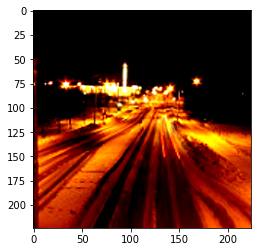

In [171]:
plot_img(test_dataset[0])

### Load the data using DataLoaders

In [172]:
from torch.utils.data import DataLoader
batch_size=32
train_dl=DataLoader(train_dataset,batch_size,shuffle=True,num_workers=3,pin_memory=True)
test_dl=DataLoader(test_dataset,batch_size*2,num_workers=3,pin_memory=True)

### Using a gpu to speed up the training process

In [173]:
import torch
# Same code used in lectures
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [174]:
device = get_default_device()
device

device(type='cuda')

In [175]:
train_dl = DeviceDataLoader(train_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

### Creating the model

In [176]:
# Base model as used in lectures
import torch.nn as nn
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

### Using pretrained model for transfer learning 

#### Pretrained model is able to achieve high accuracy in a small number of epochs since it is already trained on millions of images

In [177]:
num_of_classes=len(class_names)
num_of_classes

6

In [178]:
from torchvision import models

class IntelImageClassification(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, num_of_classes)
    
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [179]:
model=IntelImageClassification()
model

IntelImageClassification(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Seque

In [180]:
# Move model to GPU

model=to_device(model,device)

### Training the model

In [181]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.Adam):
    torch.cuda.empty_cache()
    history = []
    
    # Create a optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Set the model in training phase 
        model.train()
        train_losses = []   # to store the training loss for each batch
        lrs = []    # to store the learning rate for each batch 
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            
            lrs.append(get_lr(optimizer))   
            scheduler.step()   # update the learning rate 
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [182]:
history=[evaluate(model,test_dl)]
print(history)

[{'val_loss': 1.806740641593933, 'val_acc': 0.21931549906730652}]


In [183]:
epochs=5
max_lr=1e-3
grad_clip=0.1
weight_decay=1e-4

history+=fit(epochs,max_lr,model,train_dl,test_dl,weight_decay=weight_decay,grad_clip=grad_clip)

Epoch [0], last_lr: 0.00076, train_loss: 1.3068, val_loss: 1.4370, val_acc: 0.5332
Epoch [1], last_lr: 0.00095, train_loss: 1.3359, val_loss: 1.3194, val_acc: 0.6355
Epoch [2], last_lr: 0.00061, train_loss: 1.2813, val_loss: 1.2176, val_acc: 0.7940
Epoch [3], last_lr: 0.00019, train_loss: 1.2357, val_loss: 1.1524, val_acc: 0.8680
Epoch [4], last_lr: 0.00000, train_loss: 1.2042, val_loss: 1.1387, val_acc: 0.8890


### Testing on individual image

In [211]:


image_transform=transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Resize((224,224))])
def predict_single(image_path):
    image=Image.open(image_path)
    xb = image_transform(image)
    plt.imshow(xb.permute(1,2,0))
    xb=xb.reshape(1,3,224,224)
    xb = to_device(xb, device)
    preds = model(xb)
    max_probs,prediction=torch.max(preds,dim=1)
    
    print("Prediction: ", class_names[prediction])
    

Prediction:  buildings


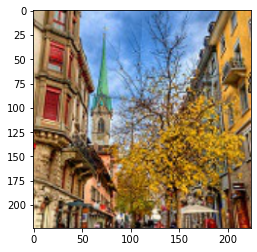

In [212]:
predict_single("../input/intel-image-classification/seg_pred/seg_pred/10004.jpg")

Prediction:  mountain


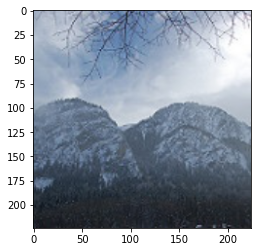

In [213]:
predict_single("../input/intel-image-classification/seg_pred/seg_pred/10013.jpg")

### Save the model

In [216]:
torch.save(model.state_dict(), 'mymodel.pth')

In [217]:
import jovian

jovian.commit(project="course-project-zerotogans",outputs=['train.csv','modified_test.csv','test.csv','modified_train.csv'])

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Detected Kaggle notebook...
[jovian] Uploading notebook to https://jovian.ai/alecy380/course-project-zerotogans


<IPython.core.display.Javascript object>